In [15]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [6]:
def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

In [3]:
def pdb_to_aa_class(pdb_file_path):

    hydrophobicity_scale = {"ALA": 1.8, "ARG": -4.5, "ASN": -3.5, "ASP": -3.5, "CYS": 2.5, "GLN": -3.5, "GLU": -3.5,
                "GLY": -0.4, "HIS": -3.2, "ILE": 4.5, "LEU": 3.8, "LYS": -3.9, "MET": 1.9, "PHE": 2.8,
                "PRO": -1.6, "SER": -0.8, "THR": -0.7, "TRP": -0.9, "TYR": -1.3, "VAL": 4.2}
    
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()
    atom_info_list = extract_pdb_info(pdb_file_path)


    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in atom_info_list if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        if atom["residue_name"] in hydrophobicity_scale:
            atom['hydrophobicity'] = hydrophobicity_scale[atom["residue_name"]]
        else:
            atom['hydrophobicity'] = None
        for key in keys_to_remove:
            atom.pop(key, None)


    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")
    
    print(f"Number of Amino Acids: {len(ca_atoms)}")
    print(ca_atoms)
    return ca_atoms

In [4]:
def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'hydrophobicity' in entry:
                ref_seq_entry['hydrophobicity'] = entry['hydrophobicity']
            
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'hydrophobicity': entry.get('hydrophobicity', 0)
                }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq

In [5]:
def plot_hydrophobicity(data, protein_id, num_residues):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    hydrophobicities = [entry['hydrophobicity'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot hydrophobicity
    plt.scatter(residue_ids, hydrophobicities, color='green', label='Hydrophobicity')

    plt.xlabel('Residue ID')
    plt.ylabel('Hydrophobicity')
    plt.title(f'{protein_id} Complete: Residue ID vs Hydrophobicity')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [34]:
def plot_hydrophobicity_bar(data,num_residues):

    # Limit the data to the specified number of residues
    if num_residues is not None:
        data = data[:num_residues]
    
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    hydrophobicities = [entry.get('hydrophobicity', 0) for entry in data]
    
    # Normalize hydrophobicity values for color mapping
    norm = mcolors.Normalize(vmin=min(hydrophobicities), vmax=max(hydrophobicities))
    cmap = plt.cm.coolwarm  # You can choose any colormap you prefer

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 1))

    # Plot a single horizontal bar with segments colored by hydrophobicity
    for i, hydrophobicity in enumerate(hydrophobicities):
        ax.barh(0, 1, left=i, color=cmap(norm(hydrophobicity)), edgecolor='none', height=1)

    # Add colorbar to reflect hydrophobicity
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a new axis for the colorbar above the plot
    cbar_ax = fig.add_axes([0.15, 2.05, 0.7, 0.05])  # [left, bottom, width, height]
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Hydrophobicity')

    # Set the x-ticks but hide the labels
    ax.set_xticks(np.arange(len(residue_ids)) + 0.5)
    ax.set_xticklabels([])
    ax.set_yticks([])  # Hide y-axis

    # Set labels and title
    ax.set_xlabel('Residue ID')
    ax.set_title('Hydrophobicity of Amino Acid Sequence')

    plt.tight_layout()
    plt.show()

Elapsed time: 0.00 seconds
Number of Amino Acids: 1616
[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'hydrophobicity': 1.9}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 2, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 3, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 4, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 5, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 6, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 7, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 8, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 9, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 10, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 11, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 

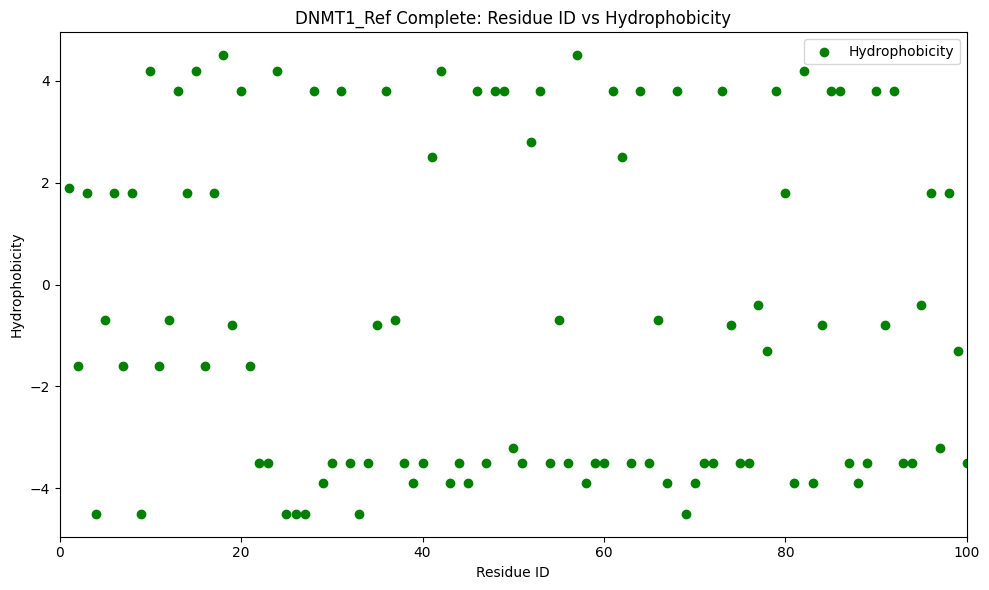

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8012.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8032.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8033.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8100.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8646.
  warnings.warn(


Elapsed time: 0.00 seconds
Number of Amino Acids: 227
[{'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 350, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 351, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 352, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'CYS', 'residue_id': 353, 'hydrophobicity': 2.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 354, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 355, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'CYS', 'residue_id': 356, 'hydrophobicity': 2.5}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 357, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 358, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'TYR', 'residue_id': 359, 'hydrophobicity': -1.3}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 360, 'hydrophobicity': 3.8}, {'chain_id': '

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19610.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19641.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19672.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 19983.
  warnings.warn(


Elapsed time: 0.01 seconds
Number of Amino Acids: 1170
[{'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 351, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 352, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'CYS', 'residue_id': 353, 'hydrophobicity': 2.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 354, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 355, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'CYS', 'residue_id': 356, 'hydrophobicity': 2.5}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 357, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 358, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'TYR', 'residue_id': 359, 'hydrophobicity': -1.3}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 360, 'hydrophobicity': 3.8}, {'chain_id': 'A', 'residue_name': 'ASP', 'residue_id': 361, 'hydrophobicity': -3.5}, {'chain_id': 

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12168.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12179.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8815.
  warnings.warn(


Elapsed time: 0.01 seconds
Number of Amino Acids: 882
[{'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 615, 'hydrophobicity': -1.6}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 616, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 617, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 618, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 619, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 620, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 621, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 622, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 623, 'hydrophobicity': 3.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 624, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'TYR', 'residue_id': 625, 'hydrophobicity': -1.3}, {'chain_id': 

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3684.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3685.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3739.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3789.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3878.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder

Elapsed time: 0.00 seconds
Number of Amino Acids: 76
[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'hydrophobicity': 1.9}, {'chain_id': 'A', 'residue_name': 'GLN', 'residue_id': 2, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 3, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'PHE', 'residue_id': 4, 'hydrophobicity': 2.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 5, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 6, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 7, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 8, 'hydrophobicity': 3.8}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 9, 'hydrophobicity': -0.7}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 10, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 11, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'T

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14866.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14904.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14934.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15120.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15121.
  warnings.warn(


Elapsed time: 0.00 seconds
Number of Amino Acids: 842
[{'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 730, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 731, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'SER', 'residue_id': 732, 'hydrophobicity': -0.8}, {'chain_id': 'A', 'residue_name': 'TRP', 'residue_id': 733, 'hydrophobicity': -0.9}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 734, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 735, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLU', 'residue_id': 736, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 737, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 738, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 739, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 740, 'hydrophobicity': -0.7}, {'chain_id': '

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14854.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15012.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15046.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15539.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15544.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBu

Elapsed time: 0.00 seconds
Number of Amino Acids: 842
[{'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 730, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 731, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'SER', 'residue_id': 732, 'hydrophobicity': -0.8}, {'chain_id': 'A', 'residue_name': 'TRP', 'residue_id': 733, 'hydrophobicity': -0.9}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 734, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 735, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLU', 'residue_id': 736, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 737, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 738, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 739, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 740, 'hydrophobicity': -0.7}, {'chain_id': '

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14730.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14766.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14800.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15144.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15147.
  warnings.warn(


Elapsed time: 0.00 seconds
Number of Amino Acids: 842
[{'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 730, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 731, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'SER', 'residue_id': 732, 'hydrophobicity': -0.8}, {'chain_id': 'A', 'residue_name': 'TRP', 'residue_id': 733, 'hydrophobicity': -0.9}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 734, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 735, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLU', 'residue_id': 736, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 737, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 738, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 739, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 740, 'hydrophobicity': -0.7}, {'chain_id': '

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14291.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14625.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 14631.
  warnings.warn(


Elapsed time: 0.00 seconds
Number of Amino Acids: 818
[{'chain_id': 'A', 'residue_name': 'ARG', 'residue_id': 730, 'hydrophobicity': -4.5}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 731, 'hydrophobicity': 4.5}, {'chain_id': 'A', 'residue_name': 'SER', 'residue_id': 732, 'hydrophobicity': -0.8}, {'chain_id': 'A', 'residue_name': 'TRP', 'residue_id': 733, 'hydrophobicity': -0.9}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 734, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'GLY', 'residue_id': 735, 'hydrophobicity': -0.4}, {'chain_id': 'A', 'residue_name': 'GLU', 'residue_id': 736, 'hydrophobicity': -3.5}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 737, 'hydrophobicity': 1.8}, {'chain_id': 'A', 'residue_name': 'VAL', 'residue_id': 738, 'hydrophobicity': 4.2}, {'chain_id': 'A', 'residue_name': 'LYS', 'residue_id': 739, 'hydrophobicity': -3.9}, {'chain_id': 'A', 'residue_name': 'THR', 'residue_id': 740, 'hydrophobicity': -0.7}, {'chain_id': '

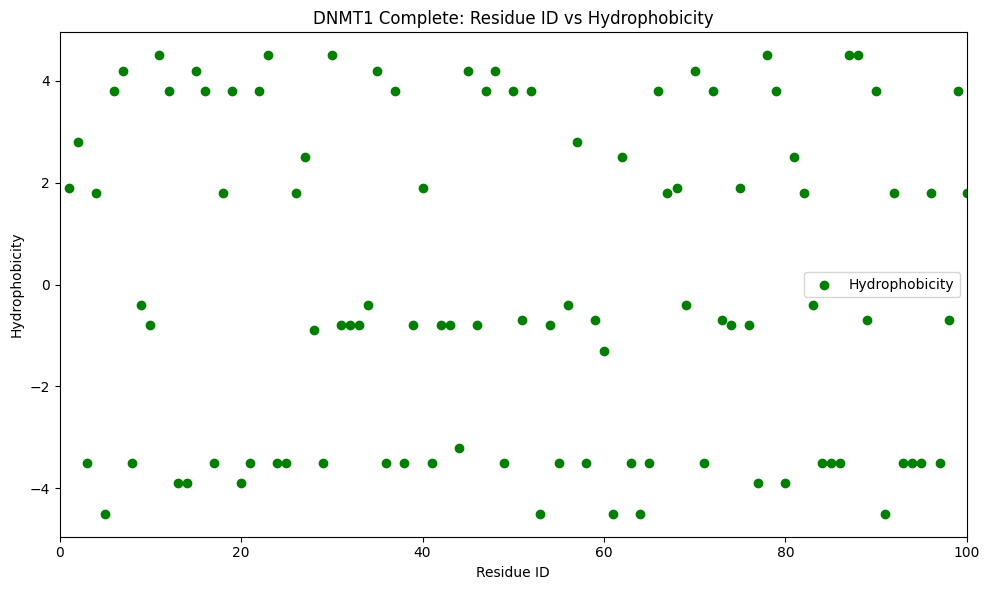

/tmp/ipykernel_1768/2447225170.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


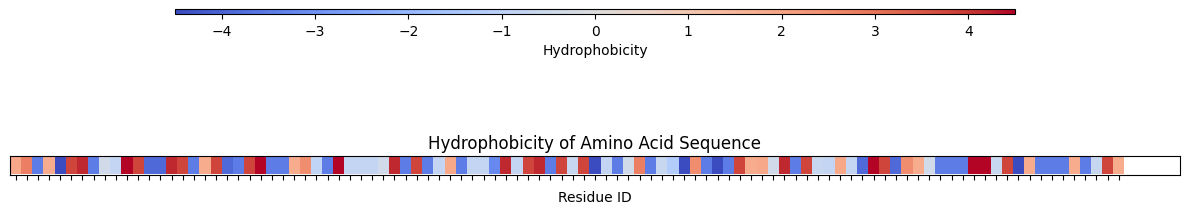

In [37]:
pdb_file_path = ['./DNMT1_pdb/pdb3epz.pdb', './DNMT1_pdb/pdb3pta.pdb', './DNMT1_pdb/pdb3swr.pdb', './DNMT1_pdb/pdb4wxx.pdb', './DNMT1_pdb/pdb4yoc.pdb', './DNMT1_pdb/pdb4z96.pdb', './DNMT1_pdb/pdb4z97.pdb', './DNMT1_pdb/pdb5wvo.pdb', './DNMT1_pdb/pdb5ydr.pdb', './DNMT1_pdb/pdb6k3a.pdb', './DNMT1_pdb/pdb6l1f.pdb', './DNMT1_pdb/pdb6x9k.pdb', './DNMT1_pdb/pdb7sfc.pdb', './DNMT1_pdb/pdb7sfe.pdb', './DNMT1_pdb/pdb7sff.pdb', './DNMT1_pdb/pdb7sfg.pdb']
ref_seq = './DNMT1_pdb/AF-P26358-F1-model_v4.pdb'

# Removed 8v9u
ref_seq = pdb_to_aa_class(ref_seq)
plot_hydrophobicity(ref_seq, protein_id='DNMT1_Ref', num_residues=100)

for pdb_file in pdb_file_path:
        completed = pdb_to_aa_class(pdb_file)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

plot_hydrophobicity(updated_ref_seq, protein_id ='DNMT1', num_residues=100)
plot_hydrophobicity_bar(ref_seq, num_residues=100)
